# Setup

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import roc_auc_score
import numpy as np
import copy

from tqdm import tqdm
import sys
sys.path.append("../../..")
from src.models import training_utils,base_model

seed = 4
data_folder = f"../../../data/processed/graph_data_nohubs/merged_types/split_dataset/seed_{seed}/"

# Load data

In [4]:
datasets, node_map = training_utils.load_data(data_folder)
train_data, val_data = datasets

full_set = torch.load(data_folder+"full_dataset.pt")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
df = pd.read_csv(data_folder+"tensor_df.csv",index_col=0)
df

,node_index,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
0,0,1,A1BG,gene_protein,disgenet,0,NaN,NaN,2.0,12.0,0.0,14.0
1,653,10422,UBAC1,gene_protein,hippie,1,NaN,NaN,0.0,36.0,0.0,36.0
2,13168,63891,RNF123,gene_protein,disgenet,2,NaN,NaN,2.0,24.0,0.0,26.0
3,6638,284403,WDR62,gene_protein,disgenet,3,NaN,NaN,14.0,18.0,0.0,32.0
4,6611,284161,GDPD1,gene_protein,hippie,4,NaN,NaN,0.0,29.0,0.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...
35834,35265,R-HSA-5579013,Defective CYP7B1 causes SPG5A and CBAS3,pathway,primekg_REACTOME,2012,NaN,NaN,0.0,1.0,0.0,1.0
35835,35260,R-HSA-5579007,Defective ACY1 causes encephalopathy,pathway,primekg_REACTOME,2013,NaN,NaN,0.0,1.0,0.0,1.0
35836,35152,R-HSA-4687000,Defective MPDU1 causes MPDU1-CDG (CDG-1f),pathway,primekg_REACTOME,2014,NaN,NaN,0.0,1.0,0.0,1.0
35837,34551,R-HSA-1855231,Synthesis of IPs in the ER lumen,pathway,primekg_REACTOME,2015,NaN,NaN,0.0,1.0,0.0,1.0


In [6]:
def run_experiment(params, train_set, val_set,negative_sampler):
    # Initialize node features
    if params["feature_type"] != "lsa":
        train_set = training_utils.initialize_features(
            train_set, params["feature_type"], params["feature_dim"]
        )
        val_set = training_utils.initialize_features(
            val_set, params["feature_type"], params["feature_dim"]
        )
    else:
        #TODO: sacar el data_folder este
        train_set = training_utils.initialize_features(
            train_set, params["feature_type"], params["feature_dim"], data_folder
        )
        val_set = training_utils.initialize_features(
            val_set, params["feature_type"], params["feature_dim"], data_folder
        )

    train_set.to(device)
    val_set.to(device)

    # Initialize model
    model = base_model.base_model(
        params, train_set.metadata(), params["supervision_types"]
    )
    model = model.to(device)

    optimizer = torch.optim.Adam(
        model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"]
    )
    train_losses = []
    val_losses = []
    train_scores = []
    val_scores = []

    epochs = params["epochs"]

    early_stopper = training_utils.EarlyStopper(params["patience"], params["delta"])
    train_label_index = train_set["gene_protein","gda","disease"]["edge_label_index"]
    for epoch in tqdm(range(epochs)):
        #Resample supervision links every k epochs
        if epoch%params["sample_epochs"] == 0:
            sample_index = torch.randint(high=train_label_index.shape[1], size=(round(params["sample_ratio"]*train_label_index.shape[1]),))
            positive_sample = train_label_index[:,sample_index]

            positive_sample = train_label_index
            new_train_label_index, new_train_label = negative_sampler.get_labeled_tensors(positive_sample,"corrupt_both")
            train_set["gene_protein","gda","disease"]["edge_label_index"] = new_train_label_index
            train_set["gene_protein","gda","disease"]["edge_label"] = new_train_label

        train_loss = training_utils.train(model, optimizer, train_set)
        val_loss = training_utils.get_val_loss(model, val_set)

        train_score = training_utils.test(model, train_set)
        val_score = training_utils.test(model, val_set)

        train_losses.append(train_loss)
        train_scores.append(train_score)

        val_scores.append(val_score)
        val_losses.append(val_loss)

        if early_stopper.early_stop(val_loss):
            print("Early stopping")
            break

    val_auc = training_utils.test(model, val_set)
    curve_data = [train_losses, val_losses, train_scores, val_scores]

    return val_auc, model, curve_data

In [7]:
from sklearn.model_selection import ParameterGrid
def perform_hyperparameter_search(param_grid, train_set, val_set,negative_sampler):
  
  default = {
      "hidden_channels":[32],
      "conv_type":["SAGEConv"],
      "batch_norm": [True],
      "dropout":[0.1],
      "micro_aggregation":["mean"],
      "macro_aggregation":["mean"],
      "layer_connectivity":[None],
      "L2_norm":[False],
      "pre_process_layers":[0],
      "msg_passing_layers":[2],
      "post_process_layers":[0],
      "normalize_output":[False],
      "jumping_knowledge":[False],

      "feature_dim":[10],
      "feature_type":["random"],
      "supervision_types":[[('gene_protein', 'gda', 'disease')]],

      'weight_decay': [1e-3],
      'lr': [0.001],
      'epochs':[400],
      "patience":[10],
      "delta":[0.1]
  }

  for arg in default:
    if arg not in param_grid:
      param_grid[arg] = default[arg]

  grid = ParameterGrid(param_grid)

  auc_results = []
  models = []

  for eid,params in enumerate(grid):
    # Launch a training experiment using the current set of parameters
    val_auc,current_model,curve_data = run_experiment(
                   params,
                   train_set,
                   val_set,
                   negative_sampler)
    
    params["auc"] = val_auc
    params["curve_data"] = curve_data

    auc_results.append(params)
    models.append(current_model)

    print(f"Validation AUC: {round(val_auc,2)}. Iteration: {eid+1} of {grid.__len__()}")

  return auc_results, models

In [8]:
test_grid = {
    "hidden_channels": [32],
    "conv_type": ["SAGEConv"],
    "batch_norm": [True],
    "dropout": [0.1],
    "micro_aggregation": ["mean"],
    "macro_aggregation": ["max"],
    "layer_connectivity": [None],
    "L2_norm": [True],
    "pre_process_layers": [1],
    "msg_passing_layers": [4],
    "post_process_layers": [1],
    "normalize_output": [False],
    "jumping_knowledge": [True],
    "heads": [2],

    "feature_dim": [10],
    "feature_type": ["lsa"],
    "supervision_types": [[('gene_protein', 'gda', 'disease')]],

    'weight_decay': [1e-3],
    'lr': [0.001],
    'epochs': [400],
    "patience": [10],
    "delta": [0.1],
    
    "sample_epochs":[10],
    "sample_ratio":[0.8]
}

negative_sampler = training_utils.NegativeSampler(full_set,("gene_protein","gda","disease"),full_set["gene_protein"]["degree_gda"],full_set["disease"]["degree_gda"])
# auc, models = perform_hyperparameter_search(test_grid,train_data,val_data,negative_sampler)

Curvita para elegir la temperatura:

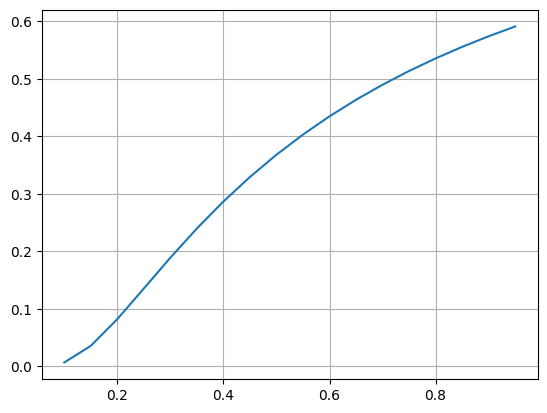

In [103]:
x = np.arange(0.1,1,0.05)
y = np.exp(-0.5/x)

plt.plot(x,y)
plt.grid(True)

In [175]:
class ParameterWalker():
    def __init__(self, start, possible_params) -> None:
        self.possible_params = possible_params
        self.start = start
        self.historial = [list(start.values())]
        self.dimensions = np.array(list(self.possible_params.keys()))
        self.current_params = copy.copy(start)
    
    def update_params(self):
        chosen_dim = np.random.choice(self.dimensions,1)[0]
        print(chosen_dim)
        values = self.possible_params[chosen_dim]
        flip_coin = np.random.choice([-1,1],1)[0]
        current_index = values.index(self.current_params[chosen_dim])
        new_index = (current_index + flip_coin)% len(values)

        new_params = copy.copy(self.current_params)
        new_params[chosen_dim] = values[new_index]
        print(new_params[chosen_dim])
        self.current_params = new_params
        return new_params
    
    def next(self):
        new_params = self.update_params()
        while list(new_params.values()) in self.historial:
            new_params = self.update_params()
        
        self.historial.append(list(new_params.values()))
        return new_params

param_walker = ParameterWalker(start_params,model_param_grid)
param_walker.historial

[[32,
  'SAGEConv',
  'mean',
  'sum',
  None,
  True,
  0,
  1,
  0,
  False,
  False,
  16,
  'random_xavier']]

In [82]:
a = param_walker.next()
a

{'hidden_channels': 32,
 'conv_type': 'SAGEConv',
 'micro_aggregation': 'mean',
 'macro_aggregation': 'sum',
 'layer_connectivity': None,
 'L2_norm': True,
 'pre_process_layers': 0,
 'msg_passing_layers': 1,
 'post_process_layers': 0,
 'normalize_output': False,
 'jumping_knowledge': True,
 'feature_dim': 16,
 'feature_type': 'random_xavier'}

Para "pre análisis": BN, dropout,lr,patience,delta,sampling k

In [179]:
model_param_grid = {
    "hidden_channels": [32, 64, 128],
    "conv_type": ["SAGEConv", "GATConv"],
    "micro_aggregation": ["mean", "sum", "max"],
    "macro_aggregation": ["mean", "sum", "max"],
    "layer_connectivity": [None, "skipcat"],
    "L2_norm": [True, False],
    "pre_process_layers": [0, 1, 2],
    "msg_passing_layers": [1, 2, 3, 4],
    "post_process_layers": [0, 1, 2],
    "normalize_output": [False, True],
    "jumping_knowledge": [True, False],
    "feature_dim": [16, 32, 64, 128],
    "feature_type": ["random", "random_xavier", "ones", "lsa"],
}

fixed_params = {
    "heads": 2,
    "batch_norm": True,
    "dropout": 0.1,
    "weight_decay": 1e-3,
    "lr": 1e-3,
    "epochs": 400,
    "patience": 10,
    "delta": 0.1,
    "sample_epochs": 10,
    "sample_ratio": 0.8,
    "supervision_types":[('gene_protein', 'gda', 'disease')]
}

start_params = {"hidden_channels":32,
                "conv_type":"SAGEConv",
                "micro_aggregation":"mean",
                "macro_aggregation":"sum",
                "layer_connectivity":None,
                "L2_norm":True,
                "pre_process_layers":0,
                "msg_passing_layers":1,
                "post_process_layers":0,
                "normalize_output":False,
                "jumping_knowledge":False,
                "feature_dim":16,
                "feature_type":"random_xavier"}

In [96]:
experiment_params = start_params|fixed_params
val_auc, model, curve_data = run_experiment(experiment_params,train_data,val_data,negative_sampler)

  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [00:37<00:00, 10.74it/s]


  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [00:39<00:00, 10.24it/s]


0.503


  0%|          | 0/10 [00:00<?, ?it/s]

macro_aggregation
max


 10%|█         | 1/10 [00:42<06:24, 42.68s/it]

0.493 True
jumping_knowledge
True


 20%|██        | 2/10 [01:33<06:20, 47.61s/it]

0.489 True
L2_norm
False


 30%|███       | 3/10 [02:21<05:32, 47.55s/it]

0.505 True
macro_aggregation
sum


 40%|████      | 4/10 [03:01<04:28, 44.80s/it]/home/ingrid/Documents/tesis/gcnn_gdas/venv/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


0.501 True
pre_process_layers
1


 50%|█████     | 5/10 [03:20<02:57, 35.45s/it]/home/ingrid/Documents/tesis/gcnn_gdas/venv/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Early stopping
0.512 True
hidden_channels
128


 60%|██████    | 6/10 [04:21<02:56, 44.15s/it]/home/ingrid/Documents/tesis/gcnn_gdas/venv/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Early stopping
0.515 True
L2_norm
True


 70%|███████   | 7/10 [08:35<05:37, 112.64s/it]/home/ingrid/Documents/tesis/gcnn_gdas/venv/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


0.515 True
micro_aggregation
max


 80%|████████  | 8/10 [13:32<05:43, 171.51s/it]

0.566 True
pre_process_layers
0


 90%|█████████ | 9/10 [15:50<02:40, 160.83s/it]

0.632 True
msg_passing_layers
4


100%|██████████| 10/10 [30:56<00:00, 185.65s/it]

0.651 True


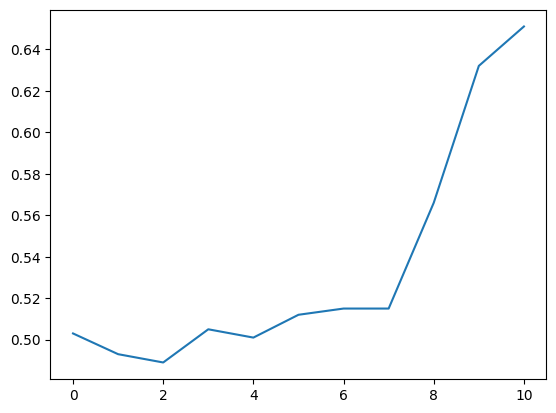

In [180]:
param_walker = ParameterWalker(start_params,model_param_grid)
T = 0.2
steps = 10
current_params = start_params|fixed_params
current_auc, current_model, curent_curve = run_experiment(experiment_params,train_data,val_data,negative_sampler)
print(current_auc)

auc_chain = [current_auc]
param_chain = [list(current_params.values())]

for i in tqdm(range(steps)):
    new_params = param_walker.next()|fixed_params
    new_auc,new_model,new_curve = run_experiment(new_params,train_data,val_data,negative_sampler)

    delta = new_auc - current_auc
    P = min([np.exp(delta/T),1])
    roll = np.random.rand()
    accept_step = roll < P 
    print(new_auc,accept_step)
    if accept_step:
        auc_chain.append(new_auc)
        param_chain.append(list(new_params.values()))
        
        current_auc = new_auc

plt.scatter(np.arange(len(auc_chain)),auc_chain)
plt.xlabel("step")
plt.ylabel("auc")
plt.grid(True)

In [187]:
param_chain[-1]

[128,
 'SAGEConv',
 'max',
 'sum',
 None,
 True,
 0,
 4,
 0,
 False,
 True,
 16,
 'random_xavier',
 2,
 True,
 0.1,
 0.001,
 0.001,
 400,
 10,
 0.1,
 10,
 0.8,
 [('gene_protein', 'gda', 'disease')]]

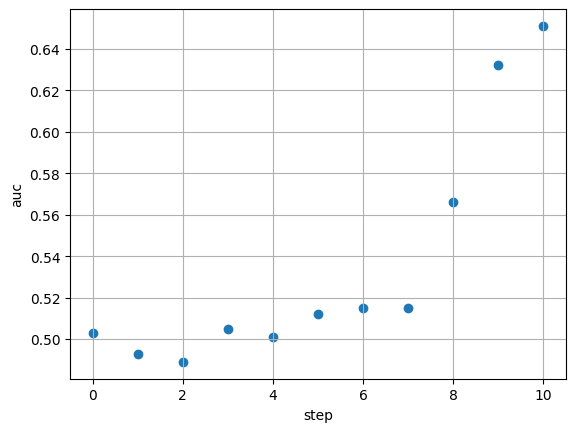

In [186]:
plt.scatter(np.arange(len(auc_chain)),auc_chain)
plt.xlabel("step")
plt.ylabel("auc")
plt.grid(True)

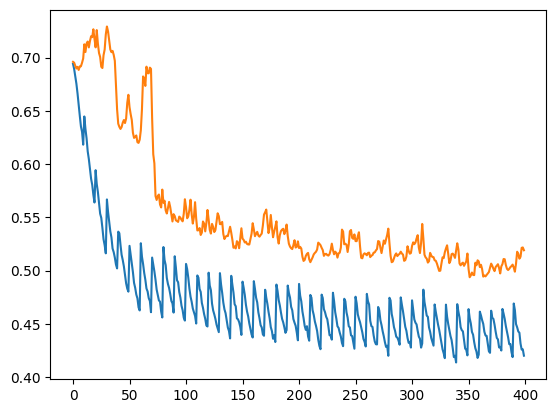

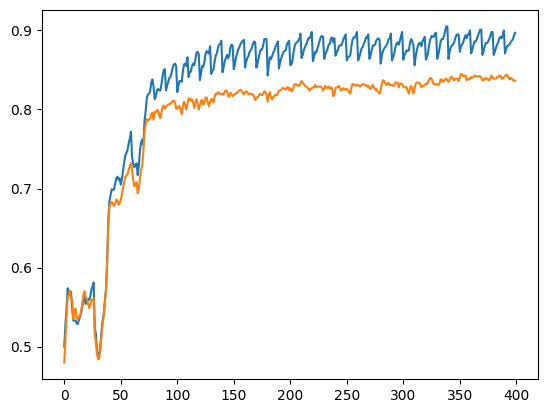

In [152]:
plt.figure()
plt.plot(curve_data[0])
plt.plot(curve_data[1])
plt.show()

plt.figure()
plt.plot(curve_data[2])
plt.plot(curve_data[3])
plt.show()